In [ ]:
%cd drive/MyDrive/Dataset/pose_estimation/cerebella/tf-pose-estimation/

/content/drive/MyDrive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
import sys
import time
import logging
import os
import random
import string
import tensorflow as tf
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import cv2 
from google.colab.patches import cv2_imshow
import math

Create a cerebella folder
- My repo was originally forked from g_sethi who had the TF2 implementation of openpose
- Clone the repository

In [ ]:
!git clone https://github.com/gsethi2409/tf-pose-estimation.git

In [ ]:
!pwd

/content/drive/MyDrive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
# move into the tf-pose folder and install the requirements
# %cd tf-pose-estimation/
!pip install -r requirements.txt
!apt-get install swig -y
%cd tf_pose/pafprocess
!swig -python -c++ pafprocess.i && python3 setup.py build_ext --inplace
!pip install git+https://github.com/adrianc-a/tf-slim.git@remove_contrib

# NOTE: You might get a warning telling you to restart your runtime... just do it and only run cells (1,2,3)

In [ ]:
 # move back 2 directories
%cd ../..

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
# these are required for the open_pose model
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

In [ ]:
# run this to check if you actually set things up correctly
# if you get a prediction.jpg in yout directory ... your good to go!

!python run.py --model=mobilenet_thin --resize=432x368 --image=./images/ski.jpg

MobileNet Thin set up

In [ ]:
# we'll start with the mobile_net model
# to begin we'll resize the images to the model's prefered dimensions
model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)

In [ ]:

# get the prediction by calling the pose estimator function
prediction = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

I modified the run file to accomodate 3d pose estimation and to run on a folder of files. The result is called run_multi.py


In [ ]:
# make a directory to store the frames
# from the video you're about to split
!mkdir square_3d

In [ ]:
!mkdir plot1_predictions

In [ ]:
!ls

In [ ]:
!python run_multi.py --model=mobilenet_thin --resize=432x368 --imgfolder=./square_3d/ --outfolder=square_3d_output/

We'll now process our input video. Mine is called cerebela1.mp4


In [ ]:
# I made this file after watching this video
# https://www.youtube.com/watch?v=yKZ_A0XzXMU

def length_of_video(video_path):
  # smaller helper function
  cap = cv2.VideoCapture(video_path)
  length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  return length

def extracting_frames(video_path, save_path,skip_frames):
  # extract frames and save them as jpg
  # video_path: path to video
  # save_path : save_directory for extracted images
  # skip_frames: save every "X" frames

  print("Extracting Frames")

  # Windows OS format
  # C;\temp\video.mp4 = C:\temp,video.mp4
  _, file_name = os.path.split(video_path)

  # tabby.mp4 = [tabby,.mp4]
  file_name_without_ext = os.path.splitext(file_name)[0]

  # check length
  length = length_of_video(video_path)
  if length == 0:
    print('Length is 0, exiting extracting phase')
    return 0

  cap = cv2.VideoCapture(video_path)
  count = 0 #keep count of frames
  added_string = "img" #DLC format


  # test first frame
  ret, frame= cap.read() #ret frame returned correctly
  test_file_path = os.path.join(
      save_path,
      file_name_without_ext[:] +\
      '{}{}.jpg'.format(added_string,count)
  )

  cv2.imwrite(test_file_path,frame)
  if os.path.isfile(test_file_path):
    print("Saving Test Frame Successfully" + " continuing Extraction Phase")

    count = 0
    while ret:
      ret,frame = cap.read()
      if ret and (count % skip_frames) == 0:
        cv2.imwrite(os.path.join(
            save_path,
            file_name_without_ext[:]+
            '{}{}.jpg'.format(added_string,count)),frame)
        count +=1
        print(count)
      else:
        count += 1
  else:
    print("Problem with Saving Test fRAME CV2 encoding, cannot save file")
    return 0

  cap.release()
  print("**********FINISHED EXTRACTION*************")


In [ ]:
# Add your video to this directory
!pwd

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
video = "squareVID.mp4"
save_path = 'square_3d/'
extracting_frames(video,save_path,skip_frames=1)

Now that we have the frames we want to collect inferences on each one of them and save them to their respective folders based on the type

In [ ]:
images = os.listdir('frames')
len(images)

150

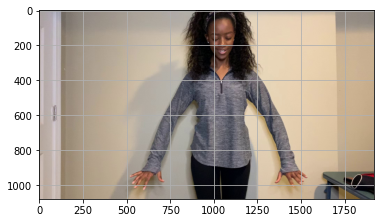

In [ ]:
image_path = 'frames/cerebella1img0.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.grid();

In [ ]:
def plot_heatmap(i):
  max_prob = np.amax(prediction.heatMat[:, :, :-1], axis=2)
  # plt.imshow(max_prob)
  plt.grid()
  plt.savefig("plain_hm/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
def plot_heatmap_on_img(i):
  max_prob = np.amax(prediction.heatMat[:, :, :-1], axis=2)
  # this allows us to change the image from one color space to another
  bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
  # we're resizing the prediction image to the original size
  bgimg = cv2.resize(bgimg, (prediction.heatMat.shape[1], prediction.heatMat.shape[0]), interpolation=cv2.INTER_AREA)
  # alpha determines how transparent a plot is
  plt.imshow(bgimg, alpha=0.5)
  plt.imshow(max_prob, alpha=0.5)
  plt.grid()
  plt.savefig("marked_2/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
def plot_black(i):
  black_background = np.zeros(image.shape)
  skeleton = TfPoseEstimator.draw_humans(black_background, humans, imgcopy=False)
  plt.figure(figsize=(15,8))
  plt.imshow(skeleton)
  plt.grid() 
  plt.axis('off')
  plt.savefig("black/"+str(i)+".jpg",bbox_inches='tight')


In [ ]:
# This allows the plots to be placed on the actual image
# Use this to place the number circles on the frame

def plot_kps_person(i):
  plt.figure(figsize=(10,10))
  plt.axis([0, image.shape[1], 0, image.shape[0]])
  # plt.scatter(*zip(*k_array), s=200, color='pink', alpha=0.6)
  plt.scatter(*zip(*keypts_array), s=200, color='pink', alpha=0.6)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(img, alpha=0.7)
  # plt.imshow(max_prob, alpha=0.5)
  ax=plt.gca() 
  ax.set_ylim(ax.get_ylim()[::-1]) 
  ax.xaxis.tick_top() 
  plt.grid();
  # for j, txt in enumerate(k_array):
  #   # I changed the offset to 3 instead of 5
  #   ax.annotate(j, (k_array[j][0]-3, k_array[j][1]+3))

  plt.savefig("marked_2/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
def solo_kps(i):
  plt.figure(figsize=(10,10))
  plt.axis([0, image.shape[1], 0, image.shape[0]])
  plt.scatter(*zip(*keypts_array))
  ax=plt.gca()
  ax.set_ylim(ax.get_ylim()[::-1])
  ax.xaxis.tick_top() 
  plt.grid();
  print("saving",i)
  plt.savefig("solo_kps/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
# make the directories to store the ourputs
# black: keypoints on a plain background
# heatmap: heatmap on image
# preds: keypoints on an image
# plain_hm : heatmaps on plain image
!mkdir black heatmap preds plain_hm solo_kps

In [ ]:
len(images)

150

In [ ]:
!mkdir marked3

In [ ]:
for i in range(0,len(virt_frames)):
  print(i)
  image_path = "frames/"+virt_frames[i]
  image = cv2.imread(image_path)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # the draw humans draws the proper keypoints on a person
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

  # You can draw the kps on a plain black background

  image = common.read_imgfile(image_path, None, None)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # get the keypoints
  if len(humans) == 1:
    keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
    # parse through the results to get the specific keypoints
    keypoints_list=[]
    for k in range (len(keypoints)-1): 
      pnt = keypoints[k][-11:-1]
      pnt = tuple(map(float, pnt.split(', ')))
      keypoints_list.append(pnt)

    # create a keypoints array
    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int) 
    # print("----------")
    # # print(keypts_array)
    # print("----------")

    k_array = [keypts_array[2], keypts_array[3], keypts_array[4], keypts_array[8]]



    # black image
    # plot_black(i)
    # plot_heatmap(i)
    # plot_heatmap_on_img(i)
    plot_kps_person(i)
    # solo_kps(i)


Frames --> Video

In [ ]:
!mkdir video

In [ ]:
%cd video/
!mkdir frames/

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/video


In [ ]:
%cd ..

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
# The first frames are the original video frames
# The naming is weird so I'll use this code
frame_names = os.listdir('frames/')
frame_names = frame_names[:25]
frame_names

In [ ]:
# I'll start by collecting the frames 
frame_files = ['frames/','heatmap/','plain_hm/','black/','preds/','solo_kps/']
folder = "holder"
for i in range(131,150):

  folder = frame_files[i//25]
  filename = folder + str(i) +'.jpg'

  # the original video frames are named in a pretty inconvenient way
  if i//25 == 0:
    filename = 'frames/' + frame_names[i]

  print(filename)
  img = cv2.imread(filename)
  out_name = "video/frames/" + str(i) +'.jpg'
  cv2.imwrite(out_name,img)

In [ ]:
%cd video/

/content/drive/MyDrive/Dataset/pose_estimation/cerebella/tf-pose-estimation/video


In [ ]:
# !mkdir openpose_combo
# I'll start by collecting the frames 
frame_files = ['marked_2/','marked3/']
folder = "openpose_combo"
for i in range(131,150):

  folder = frame_files[i//75]
  filename = folder + str(i) +'.jpg'

  img = cv2.imread(filename)
  out_name = "openpose_combo/" + str(i) +'.jpg'
  cv2.imwrite(out_name,img)

In [ ]:
from os.path import isfile, join
pathIn= 'openpose_combo/'
pathOut = 'openpose_arm_demo.mp4'
# It was a 50s video and I generated 150 frames
# Therefore I have 3fps
# I'll use 10 to make the video run faster
fps = 10
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
print(files)

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

In [ ]:
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

In [ ]:
len(frame_array)

149

In [ ]:
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    print(i)
    out.write(frame_array[i])
out.release()

Different frames --> Video file

In [ ]:
!pwd

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/video


Another video maker

In [ ]:
images = os.listdir('frames')

In [ ]:
img1 = cv2.imread("frames/"+images[0])
print(img1.shape)
img2 = cv2.imread("frames/"+images[26])
print(img2.shape)
img3 = cv2.imread("frames/"+images[56])
print(img3.shape)
img4 = cv2.imread("frames/"+images[76])
print(img4.shape)
img5 = cv2.imread("frames/"+images[116])
print(img5.shape)
img6 = cv2.imread("frames/"+images[146])
print(img6.shape)

(1080, 1920, 3)
(449, 611, 3)
(449, 524, 3)
(449, 787, 3)
(575, 604, 3)
(575, 604, 3)


In [ ]:
images = os.listdir('frames/')

In [ ]:
# I need to resize the images to the same dimesnsions
!mkdir resized_frames

width = 604
height = 575
dim = (width, height)
 

for i in range(len(images)):
  filename = "frames/"+ images[i]
  img = cv2.imread(filename)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  # cv2_imshow(resized)
  out_name = "resized_frames/" + str(i) +'.jpg'
  cv2.imwrite(out_name,resized)


After running the previous cell go back up and run the original video to frames code the one below does provide apple congruent results

In [ ]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='resized_frames'
fps=3

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('my_video.mp4')

[MoviePy] >>>> Building video my_video.mp4
[MoviePy] Writing video my_video.mp4


100%|██████████| 150/150 [00:02<00:00, 74.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_video.mp4 



ROBOT ARM: Tracking 2,3,4

In [ ]:
!pwd

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/video


In [ ]:
%cd ..
!mkdir virtual_potentiometer

In [ ]:
# move into the potentiometer folder
%cd virtual_potentiometer
!mkdir frames 

In [ ]:
%cd ..

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation


In [ ]:
# Let me get a series of frames that 
# have my arm moving in normal movement
# this is the first 24 frames

path = "frames/"
# I can't predict the names
frame_names = os.listdir('frames/')

# copy the frames into the virtual_potentiometer folder
for i in range(len(frame_names)):
  filename = "frames/"+ frame_names[i]
  img = cv2.imread(filename)
  out_name = "virtual_potentiometer/frames/" + str(i) +'.jpg'
  cv2.imwrite(out_name,img)


In [ ]:
%cd virtual_potentiometer/

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/virtual_potentiometer


In [ ]:
# make the folders for the different plot outputs
!mkdir marked_images skeletons

Code for making predictions via OpenPose

In [ ]:
!pwd

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/virtual_potentiometer


In [ ]:
virt_frames = os.listdir('frames/')

In [ ]:
# save the keypoints across time
kp_series = []
scores_series = []

I have to change the plotting code to only plot the right arm data

In [ ]:
%cd virtual_potentiometer/

/content/drive/MyDrive/Dataset/pose_estimation/cerebella/tf-pose-estimation/virtual_potentiometer


In [ ]:
!mkdir leftie 

In [ ]:
for i in range(0,len(virt_frames)):
  print(i)
  image_path = "frames/"+virt_frames[i]
  image = cv2.imread(image_path)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # the draw humans draws the proper keypoints on a person
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy = False)

  # You can draw the kps on a plain black background

  image = common.read_imgfile(image_path, None, None)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # get the keypoints
  if len(humans) == 1:
    keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
    # parse through the results to get the specific keypoints
    keypoints_list = []
    scores_list = []
    for k in range(1,len(keypoints)-1): 
      pnt = keypoints[k][-11:-1]
      pnt = tuple(map(float, pnt.split(', ')))
      keypoints_list.append(pnt)
      # I added this like to get the score
      # this will help us filter the values
      score = float(keypoints[k].split(",")[0].split(' ')[0])
      scores_list.append(score)


    # create a keypoints array
    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int) 

    

    # collect the necessary inferences
    if len(keypts_array) > 11:
      shoulder = keypts_array[2]
      elbow = keypts_array[3]
      wrist = keypts_array[4]
      hip = keypts_array[8]
      holder = [shoulder, elbow, wrist, hip]
      kp_series.append(holder)
      scores_series.append([scores_list[2], scores_list[3],scores_list[4],scores_list[8]])
      # cv2.imwrite("leftie/"+str(i)+".jpg",image)


In [ ]:
def plot_kps_person(i,pts_arr):
  plt.figure(figsize=(10,10))
  
  plt.axis([0, image.shape[1], 0, image.shape[0]])
  plt.scatter(*zip(*pts_arr), s=200, color='pink', alpha=0.6)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # plt.imshow(img)
  ax=plt.gca() 
  ax.set_ylim(ax.get_ylim()[::-1]) 
  ax.xaxis.tick_top() 
  plt.grid();
  for j, txt in enumerate(pts_arr):
    # I changed the offset to 3 instead of 5
    ax.annotate(j, (pts_arr[j][0]-3, pts_arr[j][1]+3))

  plt.savefig("marked_2/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
# This allows the plots to be placed on the actual image
# Use this to place the number circles on the frame

def plot_kps_person(i):
  plt.figure(figsize=(10,10))
  plt.axis([0, image.shape[1], 0, image.shape[0]])
  plt.scatter(*zip(*keypts_array), s=200, color='orange', alpha=0.6)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # plt.imshow(img)
  ax=plt.gca() 
  ax.set_ylim(ax.get_ylim()[::-1]) 
  ax.xaxis.tick_top() 
  plt.grid();
  for j, txt in enumerate(keypts_array):
    # I changed the offset to 3 instead of 5
    ax.annotate(j, (keypts_array[j][0]-3, keypts_array[j][1]+3))

  plt.savefig("preds/"+str(i)+".jpg",bbox_inches='tight')

In [ ]:
# colors that I have selected for potential skeletons
blush = [153, 204, 255]
red = [0,0,255]
pink = [255, 0, 255]
light_purple = [255,153,153]
purple = [255, 102, 102]
peach_cream = [100,200,255]
neon_blue = [255,255,0]
yellow = [51,255,255]
light_green = [128,255,0]
cream = [204,229,255]
dark_blue = [255, 128,0]
fun_green = [0,200,50]
mustard = [0,204,204]
fuchsia = [100,50,200]
color_map = [blush, blush, blush, red, red, pink, light_purple, purple, peach_cream,
             neon_blue, yellow, light_green,cream, fuchsia, mustard, dark_blue, fun_green]


# loop through the annotations and mark the images
for i in range(0,len(kp_series)):
  # get the image
  image_path = "leftie/" + lefties[i]
  image = cv2.imread(image_path)

  # get the frame
  # shoulder_vec = kp_series[i]
  # elbow_vec = kp_series[i]
  # wrist_vec = kp_series[i][2]
  # hip_vec = kp_series[i][3]

  # mark the image
  # I will only plot things exceeding the checkpoints
  # if scores_series[i] > 0.4:
  #   image = cv2.circle(image, (shoulder_vec[0], shoulder_vec[1]), 10, red, 5)
  # if scores_series[i] > 0.3: 
  #   image = cv2.circle(image, (elbow_vec[0], elbow_vec[1]), 10, pink, 5)
  # if scores_series[i][2] > 0.6: 
  #   image = cv2.circle(image, (wrist_vec[0], wrist_vec[1]), 10, neon_blue, 5)
  # if scores_series[i][3] > 0.6:
  #   image = cv2.circle(image, (hip_vec[0], hip_vec[1]), 10, mustard, 5)
  # plot_kps_person(i, kp_series[i])
  plt.figure(figsize=(10,10))
  
  plt.axis([0, image.shape[1], 0, image.shape[0]])
  plt.scatter(*zip(*kp_series[i]), s=200, color='pink', alpha=0.6)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # plt.imshow(img)
  ax=plt.gca() 
  ax.set_ylim(ax.get_ylim()[::-1]) 
  ax.xaxis.tick_top() 
  plt.grid();
  for j, txt in enumerate(kp_series[i]):
    # I changed the offset to 3 instead of 5
    ax.annotate(j, (kp_series[i][j][0]-3, kp_series[i][j][1]+3))

  plt.savefig("marked_2/"+str(i)+".jpg",bbox_inches='tight')
  
  
  # cv2.imwrite("marked_2/"+str(i)+'.jpg', image)

Calculate the displacement

- Wrist x --> bottom_rotate
- wrist y --> wrist_down
- elbow x --> bottom_rotate
- elbow y --> elbow down
- shoulder x --> bottom rotate
- shoulder y --> shoulder down

Angle range (down to up):
- wrist:
- elbow:
- shoulder: 

Code to calculate the angles

In [ ]:
import math
def magnitude(vec1, vec2):
  diff = vec1 - vec2
  squared =  diff ** 2
  summed = sum(squared)
  mag = math.sqrt(summed)
  return(mag)

In [ ]:
# arguments: edges --> (s,e), (e,w), (s,w)
def angle_T1(se, ew, sw):
  # cosine of the shoulder vertex
  cosS = ((sw**2)+(se**2)-(ew**2))/(2*sw*se)
  beta = round(math.acos(cosS)*(180/(math.pi)),1)
  cosE = ((ew**2)+(se**2)-(sw**2))/(2*ew*se)
  alpha = round(math.acos(cosE)*(180/(math.pi)),1)
  cosW = ((sw**2)+(ew**2)-(se**2))/(2*sw*ew)
  gamma = round(math.acos(cosW)*(180/(math.pi)),1)

  result = np.array([beta,alpha,gamma])

  return result
  

In [ ]:
# arguments: edges --> (s,e), (h,e), (s,h)
def angle_T2(se, sh, he):
  # cosine of the shoulder vertex
  cosS = ((sh**2)+(se**2)-(he**2))/(2*sh*se)
  theta = round(math.acos(cosS)*(180/(math.pi)),1)
  cosE = ((se**2)+(he**2)-(sh**2))/(2*se*he)
  omega = round(math.acos(cosE)*(180/(math.pi)),1)
  cosH = ((sh**2)+(he**2)-(se**2))/(2*sh*he)
  phi = round(math.acos(cosH)*(180/(math.pi)))

  result = np.array([theta, omega, phi])

  return result

In [ ]:
# I'm using 2 triangles to calsulate displacement
# Triangle 1: wrist(gamma), elbow(alpha), shoulder(beta)
# Triangle 2: shoulder(theta), hip(omega), elbow(phi)


# Ordering: shoulder, elbow, wrist, hip

# set global vars for prev vals:
# T1
orig_beta = 0
orig_alpha = 0
orig_gamma = 0
# T2
orig_theta = 0
orig_omega = 0
orig_phi = 0

for i in range(0,len(kp_series)):
  # get the vectors
  shoulder_vec = kp_series[i][0]
  elbow_vec = kp_series[i][1]
  wrist_vec = kp_series[i][2]
  hip_vec = kp_series[i][3]

  # calculate the magnitudes
  # T1: s,e,w
  se_mag = magnitude(shoulder_vec, elbow_vec)
  sw_mag = magnitude(shoulder_vec, wrist_vec)
  ew_mag = magnitude(elbow_vec, wrist_vec)

  # T2: s,e,h
  # I've aready calculated se in T1
  sh_mag = magnitude(shoulder_vec, hip_vec)
  he_mag = magnitude(hip_vec, elbow_vec)

  # calculate the angles
  results_T1 = angle_T1(se_mag,ew_mag,sw_mag)
  angles_T1.append(results_T1.tolist())

  results_T2 = angle_T2(se_mag,sh_mag,he_mag)
  angles_T2.append(results_T2.tolist())

  # calculate the delta T1 & T2
  original_angles_T1 = np.array([orig_beta, orig_alpha, orig_gamma]) 
  T1_frame_delta = results_T1 - original_angles_T1
  T1_delta_rounded = []
  # for some reaon some values weren't rounding
  # properly so I'll take the long route out for now
  for unit in T1_frame_delta:
    val = round(unit,1)
    T1_delta_rounded.append(val)
  delta_T1.append(T1_delta_rounded)

  original_angles_T2 = np.array([orig_theta, orig_phi, orig_omega])
  T2_frame_delta = results_T2 - original_angles_T2
  T2_delta_rounded = []
  for unit in T2_frame_delta:
    val = round(unit,1)
    T2_delta_rounded.append(val)
  delta_T2.append(T2_delta_rounded)


  # replace the original angles with the current angles 
  orig_beta, orig_aplha, orig_gamma = results_T1
  orig_theta, orig_phi, orig_omega =  results_T2
  


Code to draw the skeleton

In [ ]:
lefties = os.listdir("leftie/")

In [ ]:
!pwd

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/virtual_potentiometer


In [ ]:
!mkdir synched


I want to create code that:
1.   plots the points on the right arm T1 & T2
2.   plots the triangles in different colors
3.   Saves the images in the sequence in a folder of their own
4.   Collects the inferences of those images
5.   Creates a marked video



In [ ]:
%cd virtual_potentiometer/

/content/drive/My Drive/Dataset/pose_estimation/cerebella/tf-pose-estimation/virtual_potentiometer


In [ ]:
selected = [74,73,61,60,59,58,56,55,53,52,51,50,49,48,47,39,37,36,35,32,27,26,25,21,20,19,7,2,1,0]

In [ ]:
# Unfortunately I had to hand pick the frames 
# but in the future I want to pick frames
# if all the 4 kpts have surpassed a certain threshold

# path = "marked3/"
# copy the frames into the virtual_potentiometer folder
for i in range(0,len(selected)):
  print(i)
  filename = "frames/"+ str(selected[i])+".jpg"
  img = cv2.imread(filename)
  out_name = "synched/" + str(i) +'.jpg'
  cv2.imwrite(out_name,img)

In [ ]:
synched=os.listdir('synched/')

In [ ]:
# save the keypoints across time
kp_series = []
scores_series = []

In [ ]:
for i in range(0,len(synched)):
  print(i)
  image_path = "synched/"+synched[i]
  image = cv2.imread(image_path)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # the draw humans draws the proper keypoints on a person
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy = False)

  # You can draw the kps on a plain black background

  image = common.read_imgfile(image_path, None, None)
  humans = prediction.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

  # get the keypoints
  if len(humans) == 1:
    keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
    # parse through the results to get the specific keypoints
    keypoints_list = []
    scores_list = []
    for k in range(1,len(keypoints)-1): 
      pnt = keypoints[k][-11:-1]
      pnt = tuple(map(float, pnt.split(', ')))
      keypoints_list.append(pnt)
      # I added this like to get the score
      # this will help us filter the values
      score = float(keypoints[k].split(",")[0].split(' ')[0])
      scores_list.append(score)


    # create a keypoints array
    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int) 

    

    # collect the necessary inferences
    if len(keypts_array) > 11:
      shoulder = keypts_array[2]
      elbow = keypts_array[3]
      wrist = keypts_array[4]
      hip = keypts_array[8]
      holder = [shoulder, elbow, wrist, hip]
      kp_series.append(holder)
      scores_series.append([scores_list[2], scores_list[3],scores_list[4],scores_list[8]])
      

In [ ]:
# get the changes in degree and save them
delta_T1 = []
delta_T2 = []

# save the angles in each frame for now
angles_T1 = []
angles_T2 = []

In [ ]:
# I want to run predictions on the new data

# I'm using 2 triangles to calsulate displacement
# Triangle 1: wrist(gamma), elbow(alpha), shoulder(beta)
# Triangle 2: shoulder(theta), hip(omega), elbow(phi)


# Ordering: shoulder, elbow, wrist, hip

# set global vars for prev vals:
# T1
orig_beta = 0
orig_alpha = 0
orig_gamma = 0
# T2
orig_theta = 0
orig_omega = 0
orig_phi = 0

for i in range(0,len(kp_series)):
  # get the vectors
  shoulder_vec = kp_series[i][0]
  elbow_vec = kp_series[i][1]
  wrist_vec = kp_series[i][2]
  hip_vec = kp_series[i][3]

  # calculate the magnitudes
  # T1: s,e,w
  se_mag = magnitude(shoulder_vec, elbow_vec)
  sw_mag = magnitude(shoulder_vec, wrist_vec)
  ew_mag = magnitude(elbow_vec, wrist_vec)

  # T2: s,e,h
  # I've aready calculated se in T1
  sh_mag = magnitude(shoulder_vec, hip_vec)
  he_mag = magnitude(hip_vec, elbow_vec)

  # calculate the angles
  results_T1 = angle_T1(se_mag,ew_mag,sw_mag)
  # print("results",  results_T1)
  angles_T1.append(results_T1.tolist())

  results_T2 = angle_T2(se_mag,sh_mag,he_mag)
  angles_T2.append(results_T2.tolist())

  # calculate the delta T1 & T2
  original_angles_T1 = np.array([orig_beta, orig_alpha, orig_gamma]) 
  T1_frame_delta = results_T1 - original_angles_T1
  # print("***>",results_T1)
  T1_delta_rounded = []
  # print("--->",results_T1[1],original_angles_T1[1])

  # I can't for the life of me figure out
  # why the elbow deltas aren't calculating right
  

  # for some reaon some values weren't rounding
  # properly so I'll take the long route out for now
  for unit in T1_frame_delta:
    val = round(unit,1)
    T1_delta_rounded.append(val)
  delta_T1.append(T1_delta_rounded)

  original_angles_T2 = np.array([orig_theta, orig_phi, orig_omega])
  T2_frame_delta = results_T2 - original_angles_T2
  T2_delta_rounded = []
  for unit in T2_frame_delta:
    val = round(unit,1)
    T2_delta_rounded.append(val)
  delta_T2.append(T2_delta_rounded)


  # replace the original angles with the current angles 
  orig_beta, orig_alpha, orig_gamma = angles_T1[-1]
  orig_theta, orig_phi, orig_omega = angles_T2[-1]
  


In [ ]:
import pandas as pd
# collect the inferences
angles_t1_df = pd.DataFrame(angles_T1)
angles_t1_df.to_csv("angles_t1.csv")
angles_t2_df = pd.DataFrame(angles_T2)
angles_t2_df.to_csv("angles_t2.csv")
delta_t1_df = pd.DataFrame(delta_T1)
delta_t1_df.to_csv("delta_t1.csv")
delta_t2_df = pd.DataFrame(delta_T2)
delta_t2_df.to_csv("delta_t2.csv")

In [ ]:
kp_series[0]

[array([576, 410]),
 array([288, 421]),
 array([1152,  345]),
 array([ 921, 1036])]

Testing on a single joint

In [ ]:
# colors that I have selected for potential skeletons
blush = [153, 204, 255]
red = [0,0,255]
pink = [255, 0, 255]
light_purple = [255,153,153]
purple = [255, 102, 102]
peach_cream = [100,200,255]
neon_blue = [255,255,0]
yellow = [51,255,255]
light_green = [128,255,0]
cream = [204,229,255]
dark_blue = [255, 128,0]
fun_green = [0,200,50]
mustard = [0,204,204]
fuchsia = [100,50,200]
color_map = [blush, blush, blush, red, red, pink, light_purple, purple, peach_cream,
             neon_blue, yellow, light_green,cream, fuchsia, mustard, dark_blue, fun_green]


import numpy as np
import matplotlib.pyplot as plt

def draw_line(x1,y1,x2,y2):
  x=[-1 ,0.5 ,1,-0.5]
  y=[ 0.5,  1, -0.5, -1]
  plt.plot(x,y, 'ro')

def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

# connectpoints(x,y,0,1)
# connectpoints(x,y,2,3)

# plt.axis('equal')
# plt.show()


# loop through the annotations and mark the images
for i in range(0,len(kp_series)):
  # get the image
  image_path = "synched/" + synched[i]
  image = cv2.imread(image_path)

  # get the frame
  shoulder_vec = kp_series[i][0]
  elbow_vec = kp_series[i][1]
  wrist_vec = kp_series[i][2]
  hip_vec = kp_series[i][3]

  # mark the image by drawing the triangles

  # I will only plot things exceeding the checkpoints
  # if scores_series[i] > 0.5:
  #   image = cv2.circle(image, (shoulder_vec[0], shoulder_vec[1]), 10, red, 5)
  if scores_series[i][1] > 0.6: 
    image = cv2.circle(image, (elbow_vec[0], elbow_vec[1]), 10, pink, 5)
  # if scores_series[i][2] > 0.6: 
  #   image = cv2.circle(image, (wrist_vec[0], wrist_vec[1]), 10, neon_blue, 5)
  # if scores_series[i][3] > 0.6:
  #   image = cv2.circle(image, (hip_vec[0], hip_vec[1]), 10, mustard, 5)
  

  cv2.imwrite("marked_2/"+str(i)+'.jpg', image)

In [ ]:
# The images came out so ratchet that I might as well have a look myself
image_path = "frames/"+virt_frames[9]
image = cv2.imread(image_path)

In [ ]:
# testing on a single image
!python run.py --model=mobilenet_thin --resize=432x368 --image=./virtual_potentiometer/frames/9.jpg